##Configurações

In [1]:
!pip install scikeras==0.12.0
!pip install keras==2.15.0
!pip install tensorflow

  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Metodos Para Calcular o Theils U Coefficient
def division(measure, previousI):
  return measure / previousI

def power(measure):
  return np.power(measure, 2)

def summation(measure):
  return np.sum(measure)

def mean(N, measure):
  return (1/N) * measure

def sqrt(measure):
  return np.sqrt(measure)

def theil_u2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    N = len(y_true)

    subtractionNumerator = y_pred[1:] - y_true[1:]
    divisionNumerator = division(subtractionNumerator, y_true[:-1])
    powerNumerator = power(divisionNumerator)
    summationNumerator = summation(powerNumerator)
    meanNumerator = mean(N, summationNumerator)
    numerator = sqrt(meanNumerator)

    subtractionDenominator = y_true[1:] - y_true[:-1]
    powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
    denominator = sqrt(mean(N, summation(powerDenominator)))

    theilU2 = numerator / denominator

    return theilU2

## Modelo

In [5]:
dataset = pd.read_csv('/content/drive/My Drive/Projeto Internações/Preparação dos dados/dataset_internacoes_completo.csv')

In [6]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0
2,48,2010-01-01,AC,BRASILÉIA,22325.0
3,2,2010-01-01,AC,BUJARI,8838.0
4,4,2010-01-01,AC,CAPIXABA,9179.0
...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0


In [7]:
# Dicionário de estados para regiões
estado_para_regiao = {
    'RS': 'Sul', 'SC': 'Sul', 'PR': 'Sul',
    'SP': 'Sudeste', 'RJ': 'Sudeste', 'ES': 'Sudeste', 'MG': 'Sudeste',
    'BA': 'Nordeste', 'SE': 'Nordeste', 'AL': 'Nordeste', 'PE': 'Nordeste', 'PB': 'Nordeste',
    'RN': 'Nordeste', 'CE': 'Nordeste', 'PI': 'Nordeste', 'MA': 'Nordeste',
    'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'DF': 'Centro-Oeste',
    'AM': 'Norte', 'RR': 'Norte', 'AP': 'Norte', 'PA': 'Norte', 'TO': 'Norte', 'RO': 'Norte', 'AC': 'Norte'
}

# Adicionar a coluna de Região
dataset['Região'] = dataset['UF'].map(estado_para_regiao)

In [8]:
#Filtro por região
dataset = dataset[dataset['Região'] == 'Centro-Oeste']

In [9]:
dataset['populacao'].dtype

dtype('float64')

In [10]:
def porte(populacao):
  if populacao <= 20000:
    return 'Pequeno Porte I'
  elif populacao >= 20001 and populacao <= 50000 :
    return 'Pequeno Porte II'
  elif populacao >= 50001 and populacao <= 100000:
    return 'Médio Porte'
  elif populacao >= 100001 and populacao <= 900000:
    return 'Grande Porte'
  elif populacao >= 900001:
    return 'Metrópole'

In [11]:
def taxa_internacao (row):
  return row['Qtd. internacoes']*1000/row['populacao']

In [12]:
dataset['taxa_internacao'] = dataset.apply(taxa_internacao, axis =1)

<ipython-input-12-5efc2a6ac78c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['taxa_internacao'] = dataset.apply(taxa_internacao, axis =1)


In [13]:
dataset['Porte'] = dataset['populacao'].apply(porte)

<ipython-input-13-52a9ceda9164>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Porte'] = dataset['populacao'].apply(porte)


In [14]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,Região,taxa_internacao,Porte
803,2464,2010-01-01,DF,DISTRITO FEDERAL,NaN,Centro-Oeste,NaN,None
882,5,2010-01-01,GO,ABADIA DE GOIÁS,7000.0,Centro-Oeste,0.714286,Pequeno Porte I
883,12,2010-01-01,GO,ABADIÂNIA,16040.0,Centro-Oeste,0.748130,Pequeno Porte I
884,37,2010-01-01,GO,ACREÚNA,20644.0,Centro-Oeste,1.792288,Pequeno Porte II
885,0,2010-01-01,GO,ADELÂNDIA,2522.0,Centro-Oeste,0.000000,Pequeno Porte I
...,...,...,...,...,...,...,...,...
1021723,2,2024-04-01,MT,VALE DE SÃO DOMINGOS,3124.0,Centro-Oeste,0.640205,Pequeno Porte I
1021724,224,2024-04-01,MT,VÁRZEA GRANDE,258537.0,Centro-Oeste,0.866414,Grande Porte
1021725,5,2024-04-01,MT,VERA,10476.0,Centro-Oeste,0.477281,Pequeno Porte I
1021726,2,2024-04-01,MT,VILA BELA DA SANTÍSSIMA TRINDADE,14834.0,Centro-Oeste,0.134825,Pequeno Porte I


Filtro

In [15]:
dataset = dataset[dataset['Porte'] == 'Grande Porte']

In [16]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,Região,taxa_internacao,Porte
888,108,2010-01-01,GO,ÁGUAS LINDAS DE GOIÁS,162245.0,Centro-Oeste,0.665660,Grande Porte
897,607,2010-01-01,GO,ANÁPOLIS,340632.0,Centro-Oeste,1.781982,Grande Porte
900,438,2010-01-01,GO,APARECIDA DE GOIÂNIA,463854.0,Centro-Oeste,0.944263,Grande Porte
970,105,2010-01-01,GO,FORMOSA,101885.0,Centro-Oeste,1.030574,Grande Porte
1016,84,2010-01-01,GO,LUZIÂNIA,177671.0,Centro-Oeste,0.472784,Grande Porte
...,...,...,...,...,...,...,...,...
1021585,158,2024-04-01,MS,TRÊS LAGOAS,103691.0,Centro-Oeste,1.523758,Grande Porte
1021624,242,2024-04-01,MT,CUIABÁ,564062.0,Centro-Oeste,0.429031,Grande Porte
1021696,186,2024-04-01,MT,RONDONÓPOLIS,200074.0,Centro-Oeste,0.929656,Grande Porte
1021714,44,2024-04-01,MT,SINOP,115759.0,Centro-Oeste,0.380100,Grande Porte


In [17]:
time_series = dataset[['Data completa', 'taxa_internacao']]
time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])

<ipython-input-17-8980fe5bf9f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])


In [18]:
time_series = time_series.set_index('Data completa').resample('M').mean()

In [19]:
time_series

,taxa_internacao
Data completa,
2010-01-31,1.097339
2010-02-28,1.043002
2010-03-31,1.017372
2010-04-30,0.990271
2010-05-31,0.999323
...,...
2023-12-31,0.770411
2024-01-31,0.770887
2024-02-29,0.739992


In [20]:
time_series = time_series['2010-1-1':'2024-04-30']

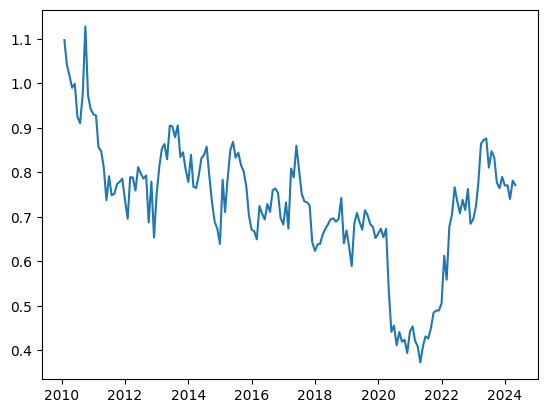

In [21]:
plt.plot(time_series)

In [22]:
time_series

,taxa_internacao
Data completa,
2010-01-31,1.097339
2010-02-28,1.043002
2010-03-31,1.017372
2010-04-30,0.990271
2010-05-31,0.999323
...,...
2023-12-31,0.770411
2024-01-31,0.770887
2024-02-29,0.739992


In [23]:
train_data= time_series.values

#Normaliza os Dados
normalizer = MinMaxScaler(feature_range=(0,1))
train_data = normalizer.fit_transform(train_data)

#Cria os Arrays No Formato Certo
x = []
y = []
for i in range(12, len(train_data)):
  x.append(train_data[i-12:i, 0])
  y.append(train_data[i,0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1],1))

#Converte os Dados Para Float
x = np.asarray(x).astype('float32')
y = np.asarray(y).astype('float32')


In [24]:
len(x)

160

In [25]:
x_train, y_train = x[:132], y[:132]
x_test, y_test = x[132:], y[132:]



In [26]:
len(x_test)

28

In [27]:
#Cria o Modelo De Rede Neural
dropout_val = 0.2
regressor = Sequential()
regressor.add(LSTM(units = 800, return_sequences = True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 300, return_sequences = True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 200))
regressor.add(Dropout(dropout_val))

regressor.add(Dense(units = 1, activation ='linear'))

regressor.compile(optimizer = 'adam', loss= 'mean_squared_error',
                  metrics = ['mean_squared_error'])


regressor.fit(x_train, y_train, epochs = 100, batch_size=16)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - loss: 0.1476 - mean_squared_error: 0.1476
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - loss: 0.0802 - mean_squared_error: 0.0802
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step - loss: 0.0260 - mean_squared_error: 0.0260
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/step - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.0172 - mean_squared_error: 0.0172
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 359ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - loss: 0.0152 - mean_squared_error: 0.0152
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/s

In [28]:
y_test = y_test.reshape(-1, 1)
train_predictions = regressor.predict(x_test)
train_predictions = normalizer.inverse_transform(train_predictions)
y_test = normalizer.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


In [29]:
train_results = pd.DataFrame(zip(train_predictions, y_test), columns = ['previsao', 'valor_real'])
train_results['previsao'] = train_results['previsao'].apply(lambda x: x[0])
train_results['valor_real'] = train_results['valor_real'].apply(lambda x: x[0])
forecasts = train_results['previsao']
#train_results

In [30]:
start_date = "2022-1-31"
train_results['data'] = pd.date_range(start=start_date, periods=len(train_results), freq='M')
train_results.set_index('data', inplace=True)

In [31]:
train_results

,previsao,valor_real
data,,
2022-01-31,0.511637,0.612279
2022-02-28,0.571223,0.558587
2022-03-31,0.594874,0.677755
2022-04-30,0.635682,0.704669
2022-05-31,0.693139,0.766824
2022-06-30,0.742412,0.735101
2022-07-31,0.742131,0.707964
2022-08-31,0.714595,0.738084
2022-09-30,0.721680,0.715456


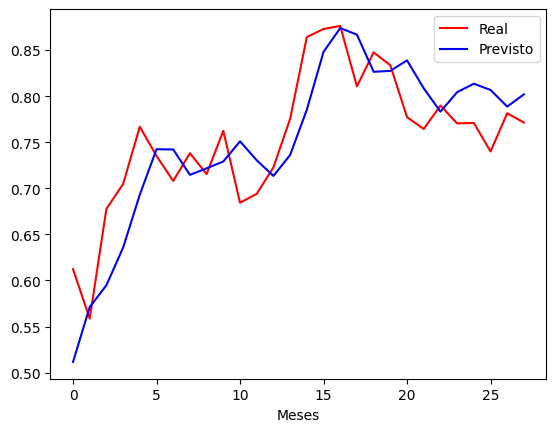

In [32]:
plt.plot(y_test, color='red', label = 'Real')
plt.plot(forecasts, color='blue', label = 'Previsto')
plt.xlabel('Meses')
plt.legend()
plt.show()

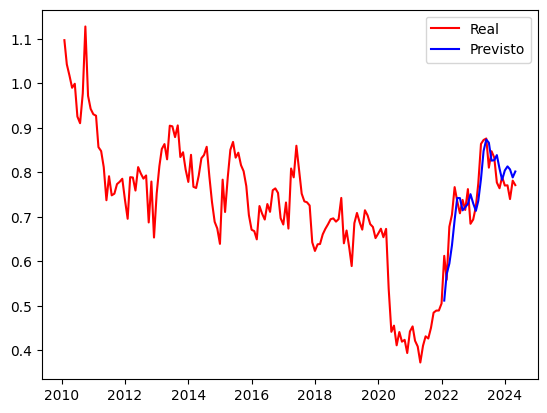

In [33]:
plt.plot(time_series, color='red', label = 'Real')
plt.plot(train_results['previsao'], color='blue', label = 'Previsto')
plt.legend()
plt.show()

In [34]:
mse = mean_squared_error(y_test, forecasts)

In [35]:
mse

0.002224317

In [36]:
rmse = np.sqrt(mse)

In [37]:
rmse

0.047162667

In [38]:
tu = theil_u2(y_test, forecasts)

In [39]:
tu

0.9092943034786741

In [40]:
# Salva o DataFrame em um arquivo CSV
train_results.to_csv('predicao_previne_brasil_grande_porte_sem_dados_inputados(2010)_centro-oeste.csv', index=False)